In [6]:
import mujoco
import mediapy as media
import numpy as np

model = mujoco.MjModel.from_xml_path("../robot_models/kuka_iiwa/scene.xml")
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

DURATION = 2    # seconds 
FRAMERATE = 150  # Hz
NUM_FRAMES = DURATION * FRAMERATE

# Create and configure camera
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

# Reset to home position defined in keyframe
mujoco.mj_resetDataKeyframe(model, data, 1)


def rotate(neg: int = 0):
    target = data.qpos.copy()

    frames = []
    frame_time = 1.0 / FRAMERATE
    next_frame_time = 0

    target_joint_0 = 0
    while len(frames) < NUM_FRAMES:
        # Keep all joints at current position except last one
        data.ctrl = target
        data.ctrl[0] = target_joint_0
        target_joint_0 = target_joint_0 + 0.01 if not neg else target_joint_0 - 0.01
        
        # Step simulation
        mujoco.mj_step(model, data)
        
        # Render frame at fixed intervals
        if data.time >= next_frame_time:
            camera.lookat = data.body('base').subtree_com
            renderer.update_scene(data, camera)
            pixels = renderer.render()
            frames.append(pixels)
            next_frame_time += frame_time
    return frames   

# Display animation
frames = rotate(neg=1)
media.show_video(frames, fps=30)
print(model.actuator_ctrlrange)

[[-2.96706  2.96706]
 [-2.0944   2.0944 ]
 [-2.96706  2.96706]
 [-2.0944   2.0944 ]
 [-2.96706  2.96706]
 [-2.0944   2.0944 ]
 [-3.05433  3.05433]]


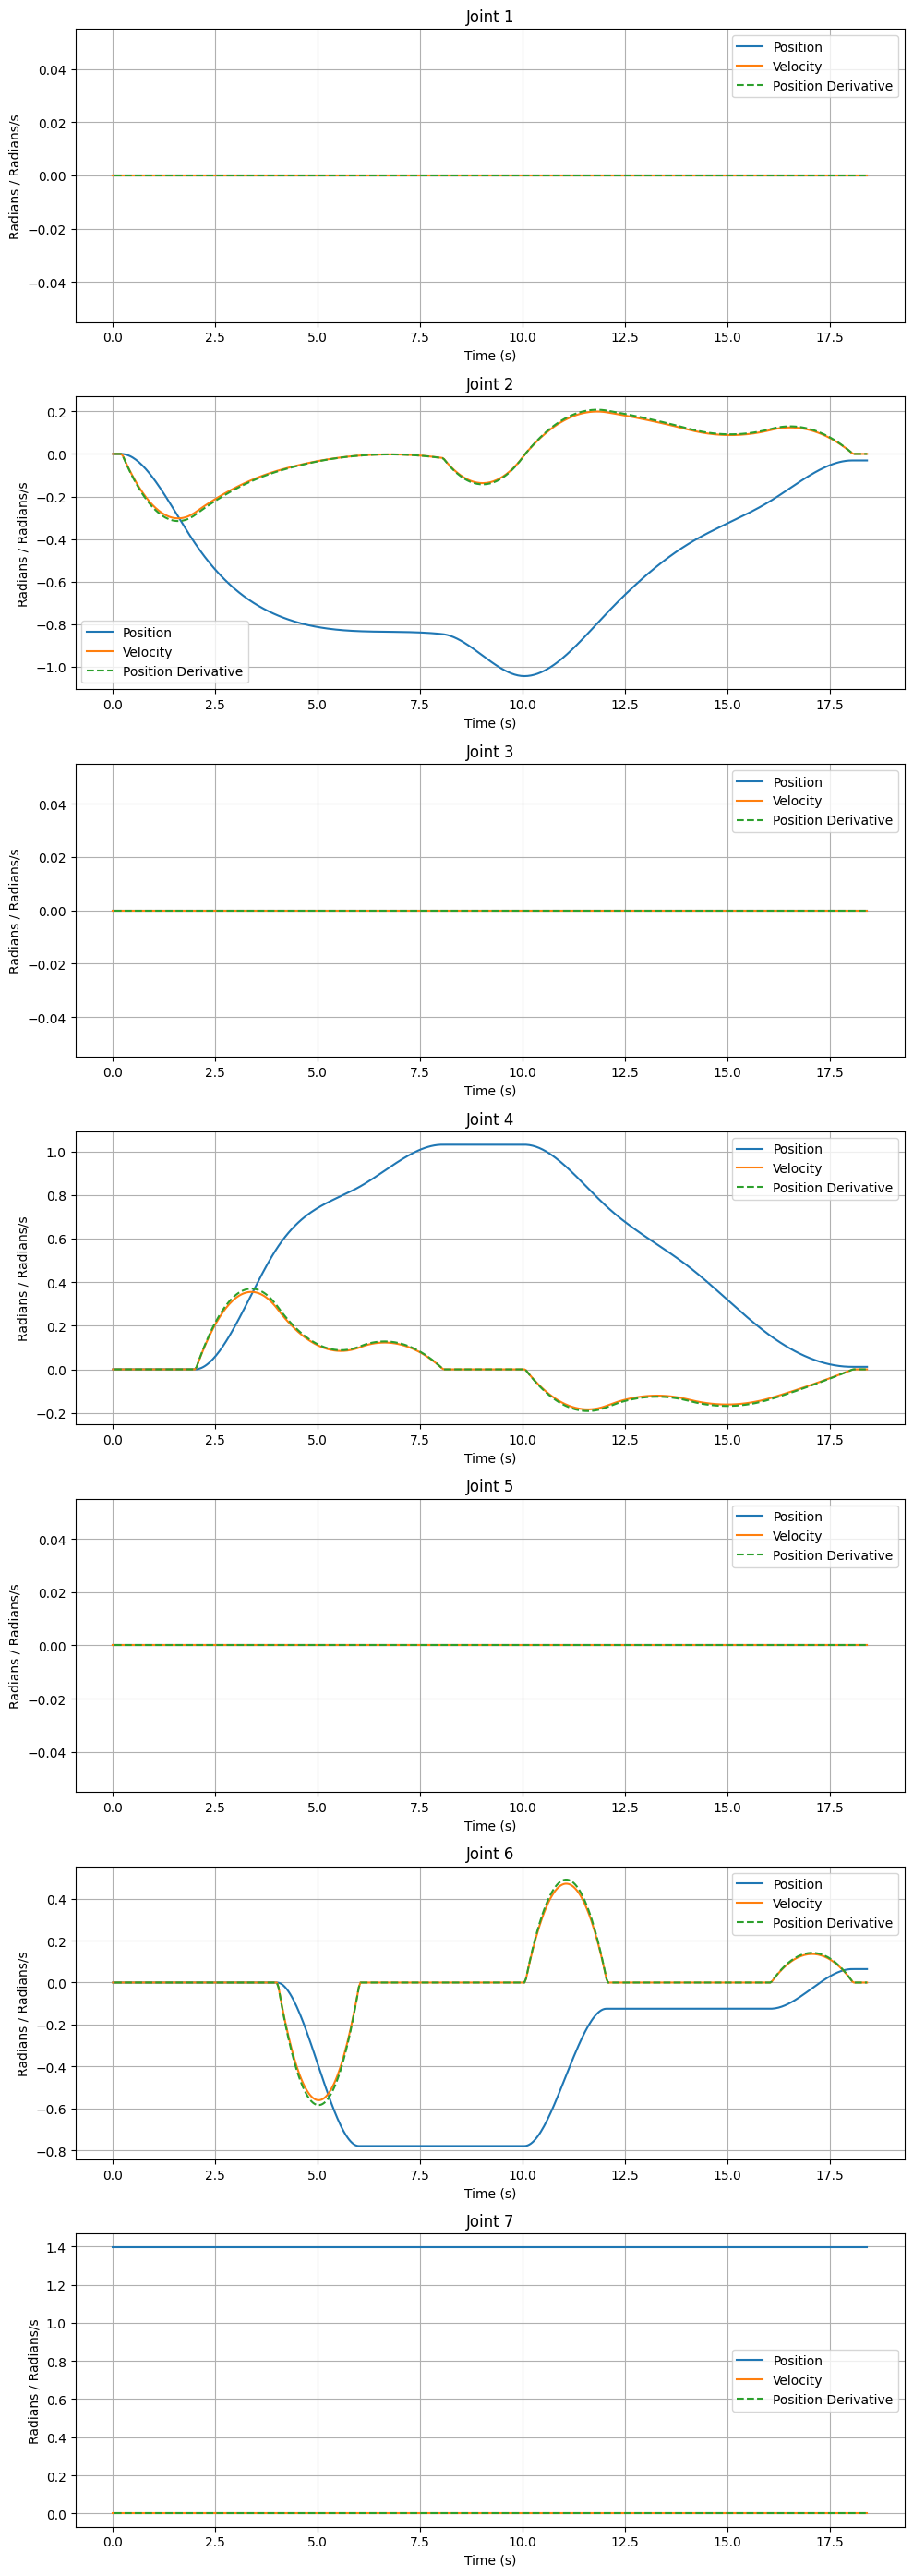

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def robot_data_to_qpos_qvel(animation_df: pd.DataFrame, num_q: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Convert raw robot data from animation to qpos and qvel

    Args:
        animation_df: dataframe containing the robot data
        num_q: number of qpos/qvel variables

    Returns:
        qpos: numpy array of shape (num_frames, num_q)
        qvel: numpy array of shape (num_frames, num_q)
    """
    num_frames = len(animation_df)
    qpos = np.zeros((num_frames, num_q))
    qvel = np.zeros((num_frames, num_q))
    
    link_names = [f'LinkN{i}' for i in range(1, num_q + 1)] 
    
    for i, link in enumerate(link_names):
        qpos_col = f'qpos_{link}'
        qvel_col = f'qvel_{link}'
        qpos[:, i] = animation_df[qpos_col].values
        qvel[:, i] = animation_df[qvel_col].values
        
    return qpos, qvel

def process_raw_robot_data(input_csv: str) -> pd.DataFrame:
    df = pd.read_csv(input_csv)
    cleaned_df = clean_robot_data(df)
    link_dfs = process_link_data(cleaned_df)
    merged_df = merge_link_data(link_dfs)
    return merged_df


def clean_robot_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean raw robot data by filtering out unwanted links and handling special cases.

    Args:
        df: Raw dataframe containing robot data

    Returns:
        Cleaned dataframe with only relevant link data
    """
    filtered_df = df[~df['Link'].str.contains('Axis')]
    links = ["LinkN0", "LinkN1", "LinkN2", "LinkN3", "LinkN4", "LinkN5", "LinkN6", "LinkN7"]
    cleaned_df = filtered_df[filtered_df['Link'].isin(links)]
    return cleaned_df


def process_link_data(df: pd.DataFrame) -> dict[str, pd.DataFrame]:
    """
    Process cleaned data into separate dataframes for each link.

    Args:
        df: Cleaned dataframe containing robot data

    Returns:
        Dictionary mapping link names to their respective dataframes
    """
    links = ["LinkN0", "LinkN1", "LinkN2", "LinkN3", "LinkN4", "LinkN5", "LinkN6", "LinkN7"]
    link_dfs = {}

    for link in links:
        link_dfs[link] = df[df['Link'] == link].reset_index(drop=True)
        if link != "LinkN7":
            link_dfs[link]['qpos'] = link_dfs[link]['Y_Rotation']
            link_dfs[link]['qvel'] = link_dfs[link]['Y_Velocity']
        else:
            link_dfs[link]['qpos'] = link_dfs[link]['Z_Rotation']
            link_dfs[link]['qvel'] = link_dfs[link]['Z_Velocity']

    return link_dfs


def merge_link_data(link_dfs: dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Merge all link data into a single dataframe.

    Args:
        link_dfs: Dictionary of dataframes for each link

    Returns:
        Merged dataframe containing all link data
    """
    links = list(link_dfs.keys())
    merged_df = link_dfs[links[0]][['Frame', 'qpos', 'qvel']].copy()
    merged_df.rename(columns={
        'qpos': f'qpos_{links[0]}',
        'qvel': f'qvel_{links[0]}'
    }, inplace=True)

    for link in links[1:]:
        link_data = link_dfs[link][['Frame', 'qpos', 'qvel']].copy()
        link_data.rename(columns={
            'qpos': f'qpos_{link}',
            'qvel': f'qvel_{link}'
        }, inplace=True)
        merged_df = pd.merge(merged_df, link_data, on='Frame')

    return merged_df

animation_df = process_raw_robot_data("../data/kuka_2.csv")
target_qpos, target_qvel = robot_data_to_qpos_qvel(animation_df, model.nq)


# Plot position and velocity for each joint
fig, axes = plt.subplots(model.nq, 1, figsize=(10, 4*model.nq))
time = np.arange(len(target_qpos)) / 25#53.0  # Using 153 Hz from animation_fps

target_qpos[:,3] *= -1
target_qvel[:,3] *= -1

# Calculate position derivative
dt = 1/25#/153.0  # Time step
qpos_derivative = np.zeros_like(target_qpos)
qpos_derivative[1:] = (target_qpos[1:] - target_qpos[:-1]) / dt

for joint in range(model.nq):
    ax = axes[joint]
    ax.plot(time, target_qpos[:, joint], label='Position')
    ax.plot(time, target_qvel[:, joint], label='Velocity')
    ax.plot(time[1:], qpos_derivative[1:, joint], '--', label='Position Derivative')
    ax.set_title(f'Joint {joint+1}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Radians / Radians/s')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [6]:
print(len(target_qpos))

461


In [8]:

mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
for frame in range(len(target_qpos)):
    # Keep all joints at current position except last one
    data.ctrl = -target_qpos[frame]
    # data.ctrl[3] *= -1 # already been multiplied above 
    #data.ctrl[0] += np.random.randn() * 9  # Random offset only for last joint
    
    # Step simulation
    mujoco.mj_step(model, data)
    # Render and save frames
        # Set camera to look at link3
    camera.lookat = data.body('link3').subtree_com
    
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

# Display animation
media.show_video(frames, fps=153)

In [21]:
print(model.opt.timestep)

0.002


In [22]:
data.qfrc_applied

array([0., 0., 0., 0., 0., 0., 0.])

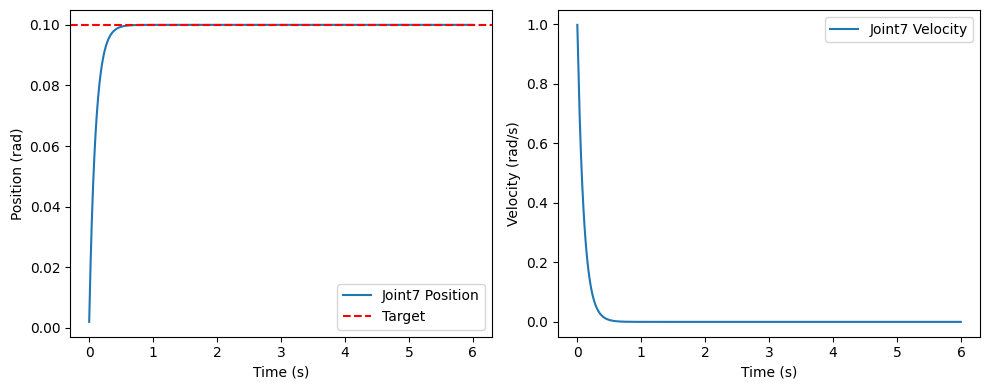

In [23]:
import matplotlib.pyplot as plt
actuator_index = 6

mujoco.mj_resetDataKeyframe(model, data, 1)

# Set initial control targets for all actuators
data.ctrl[:] = 0.0

# Run simulation for a few steps to get initial state
for _ in range(100):
    mujoco.mj_step(model, data)

# Record data lists for analysis
time_steps = []
joint7_positions = []
joint7_velocities = []
applied_controls = []

# Simulation settings
dt = model.opt.timestep
simulation_steps = 3000

# Apply a step command to joint7
desired_setpoint = 0.1  # radians
data.ctrl[actuator_index] = desired_setpoint

for step in range(simulation_steps):
    mujoco.mj_step(model, data)
    time_steps.append(step * dt)
    # Access joint state by name or index. Here we assume joint7 index is 6.
    joint7_positions.append(data.qpos[6])
    joint7_velocities.append(data.qvel[6])
    applied_controls.append(data.actuator_force[actuator_index])  # if available

# Plot the response
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(time_steps, joint7_positions, label='Joint7 Position')
plt.axhline(desired_setpoint, color='r', linestyle='--', label='Target')
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_steps, joint7_velocities, label='Joint7 Velocity')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (rad/s)")
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
print(model.nu)

7


In [15]:
a = np.ones(10)
b = -np.ones(10)
re = np.linalg.norm(a - b, axis=0)

In [14]:
loss

np.float64(3.1622776601683795)